**Curso de Inteligencia Artificial y Aprendizaje Profundo**


# Predicción del valor de una acción. Tata Global Beverage (LSTM)

##  Autores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Oleg Jarma, ojarmam@unal.edu.co
4. Maria del Pilar Montenegro, pmontenegro88@gmail.com

## Contenido

* [Introducción](#Introducción)
* [Importar las librería requeridas](#Importar-las-librería-requeridas)
* [Funciones-para-graficar-predicciones](#Funciones-para-graficar-predicciones)
* [Lectura de los datos](#Lectura-de-los-datos)
* [Extrae datos para la serie que se desea predecir-close](#Extrae-datos-para-la-serie-que-se-desea-predecir-close)
* [Visualización de la serie precio al cierre](#Visualización-de-la-serie-precio-al-cierre)
* [Preparación de los datos para el entrenamiento](#Preparación-de-los-datos-para-el-entrenamiento)
* [Crea el modelo LSTM](#Crea-el-modelo-LSTM)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Predicciones](#Predicciones)

## References

1. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
2. Ralf C. Staudemeyer and Eric Rothstein Morris,[*Understanding LSTM a tutorial into Long Short-Term Memory Recurrent Neural Networks*](https://arxiv.org/pdf/1909.09586.pdf), arxiv, September 2019
3. Karpathy, [*The Unreasonable Effectiveness of Recurrent Neural Networks*](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
4. Anton Lucanus, [Making Automation More Efficient by Learning from Historical Trade Data](https://datafloq.com/read/making-automation-more-efficient-by-learning-from-/7444), 8:43 AM, January 7, 2020
5. https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
6. https://www.youtube.com/watch?v=2BrpKpWwT2A&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ&index=1
7. https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653
8. https://github.com/llSourcell/Reinforcement_Learning_for_Stock_Prediction/blob/master/README.md


## Importar las librería requeridas

In [1]:
#
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM
print("Versión de Tensorflow: ", tf.__version__)


Versión de Tensorflow:  2.1.0


# Funciones para graficar predicciones

In [2]:
# Funciones auxiliares
#
def plot_prediction(real, prediccion):
    plt.plot(real,color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

#

## Lectura de  los datos

Estos datos corresponden a la empresa *Tata Global Beverages*. Son  1235 datos que corresponden a observaciones del precio de la acción, el número de transacciones de la acción (compra-venta). Los datos son diarios (dias hábiles o comerciales). Están entre el 8 de octubre de 2013 hasta el 8 de octubre de 2018.

la columna *Date* es la fecha, *Open* es el valor de acción a la apertura del mercado, *High* el valor más alto alcanzado en el día, *Low* el valor más bajo del día, *Close* el valor al cierre, *Total_Trade_Quantity* el total de acciones transadas y *Turnover_Lacs* índice de rotación.

In [3]:
#Data extracted from Quandl: https://www.quandl.com/data/NSE/TATAGLOBAL-Tata-Global-Beverages-Limited
#File downloaded from: https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/03/NSE-TATAGLOBAL11.csv
#reading a local file
#df = pd.read_csv('NSE-TATAGLOBAL11.csv')
#df.head()

#For Colab
# pip install google-colab
#from google.colab import files
#uploaded = files.upload()
#df = pd.read_csv('NSE-TATAGLOBAL11.csv')


#reading from a local file
df = pd.read_csv('../Datos/NSE-TATAGLOBAL11.csv')


In [5]:
# looking at the first five rows of the data
print('\n Shape of the data:')
print(df.shape)
df.head()


 Shape of the data:
(1235, 8)


,Date,Open,High,Low,Last,Close,Total_Trade_Quantity,Turnover_Lacs
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


Vamos a cambiar el índice de los datos. Tomaremos la fecha como indice: *df.index*. Los datos se reordenan para invertir la tabla, debido a que los datos contienen las observaciones más recientes en la parte superior de la tabla.

## Extrae datos para la serie que se desea predecir-close

In [6]:
#creating dataframe with date and the target variable

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(df[['Date', 'Close']])
#
#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

,Close
Date,
2013-10-08,155.80
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


## Visualización de la serie precio al cierre


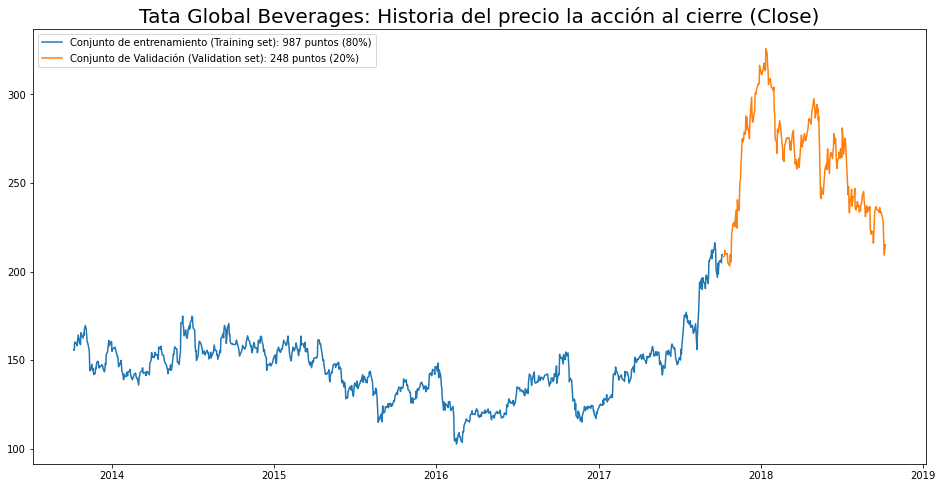

In [7]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data[:987], label='Conjunto de entrenamiento (Training set): 987 puntos (80%)')
plt.plot(data['Close'][987:], label='Conjunto de Validación (Validation set): 248 puntos (20%)') #248 data
plt.title("Tata Global Beverages: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

## Preparación de los datos para el entrenamiento de la red LSTM

Para evitar problemas con las tendencias y para mejorar la estimación (entrenamiento) los datos se van a transformar a la escala $[0,1]$. Para las predicciones se utiliza la transformación inversa.



### Primero extrae los valores y se crea el  objeto MinMaxScaler

In [8]:
#creating train and test sets
dataset = data.values

# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

##  Crea datos de entrenamiento 

 La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 5 datos (la predicción a
 partir de esos "time_step" datos se hace para los siguentes 5 días). Se conformará de esta forma el set de entrenamiento

1. Número de datos consecutivos para entrenamiento: time_step = 60. 
2. Días a predecir: days = 1

In [39]:
# tamaños para entrenamiento y validación
len_train = 987 # 80%
len_valid = 248 # 20%
len_data = len_train + len_valid
# 
# Longitud de las tiras de datos para hacer las predicciones
time_step = 60
# días a predecir
days = 1
#
# crea datos de entrenamiento
x_train, y_train = [], []
#
for i in range(time_step ,len_train ):
    # x: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    x_train.append(scaled_data[i-time_step :i,0])
    # y: el siguiente dato
    y_train.append(scaled_data[i:i+days,0])
x_train, y_train = np.array(x_train), np.array(y_train)
#
#
# Arregla el tamaño, porque la capa LSTM espera tensores de tres dimensiones: 
# (batch, longitud de la tira de datos, número de features)
# Como es una serie univariada solamente hay 1 feature.
#
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],1))
#
print(x_train.shape)
print(y_train.shape)



(927, 60, 1)
(927, 1, 1)


##  Crea el modelo LSTM

In [44]:
# unidades de salida de las capas LSTM
#
units = 70
#
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1],1)),
    tf.keras.layers.LSTM(units=units),
    tf.keras.layers.Dense(1)])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 60, 70)            20160     
_________________________________________________________________
lstm_26 (LSTM)               (None, 70)                39480     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 71        
Total params: 59,711
Trainable params: 59,711
Non-trainable params: 0
_________________________________________________________________


##  Compila

Se usará el optimizador Adam y la función de pérdida MSE

In [57]:
model.compile(loss='mse', optimizer='adam')


# Entrena el modelo


In [58]:
history = model.fit(x_train,y_train,epochs=20,batch_size=32)

Train on 927 samples
Epoch 1/40
927/927 [==============================] - 11s 12ms/sample - loss: 3.4799e-04
Epoch 2/40
927/927 [==============================] - 5s 5ms/sample - loss: 2.5662e-04
Epoch 3/40
927/927 [==============================] - 4s 4ms/sample - loss: 2.2893e-04
Epoch 4/40
927/927 [==============================] - 4s 4ms/sample - loss: 2.3416e-04
Epoch 5/40
927/927 [==============================] - 4s 4ms/sample - loss: 2.4122e-04
Epoch 6/40
927/927 [==============================] - 4s 4ms/sample - loss: 2.2925e-04
Epoch 7/40
927/927 [==============================] - 4s 4ms/sample - loss: 2.1276e-04
Epoch 8/40
927/927 [==============================] - 4s 4ms/sample - loss: 2.0267e-04
Epoch 9/40
927/927 [==============================] - 4s 4ms/sample - loss: 2.0084e-04
Epoch 10/40
927/927 [==============================] - 4s 4ms/sample - loss: 1.8270e-04
Epoch 11/40
927/927 [==============================] - 4s 4ms/sample - loss: 1.8572e-04
Epoch 12/40
927/92

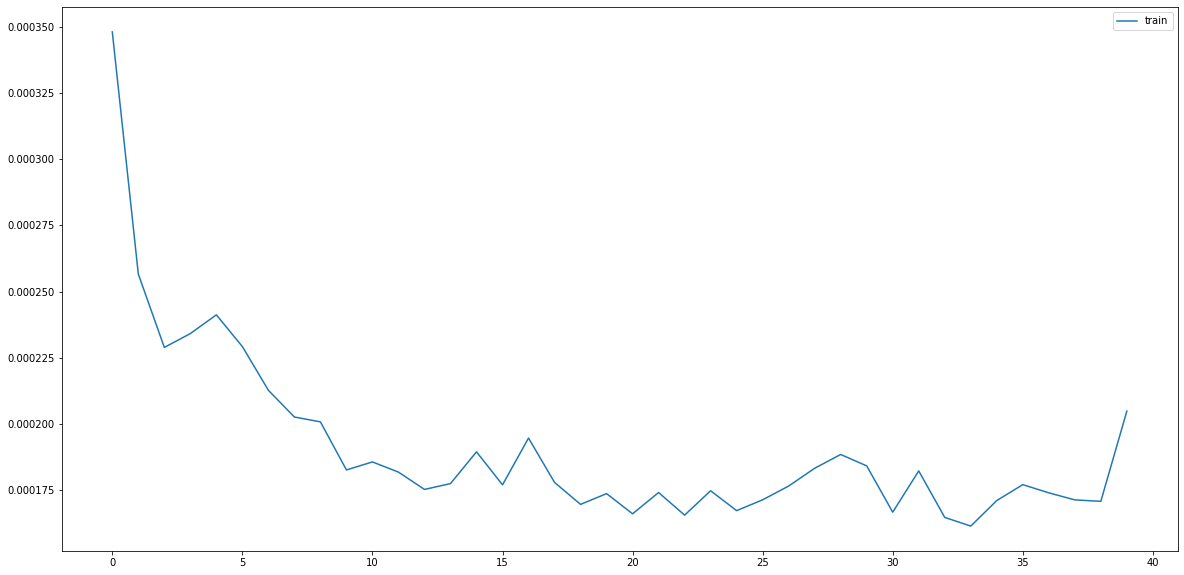

In [59]:
plt.plot(history.history['loss'], label='train')
plt.legend();

## Predicciones

### Prepara los datos de validación

In [60]:
inputs = data[len_data - len_valid - time_step:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_test = []
y_test = []

# aqui vamos

for i in range(time_step,inputs.shape[0]):
    x_test.append(inputs[i-time_step:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


In [29]:
x_test.shape

(248, 60, 1)

### Calcula predicciones

In [61]:
# predictions
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

In [31]:
prediction.shape

(248, 1)

### Gráfica de las predicciones

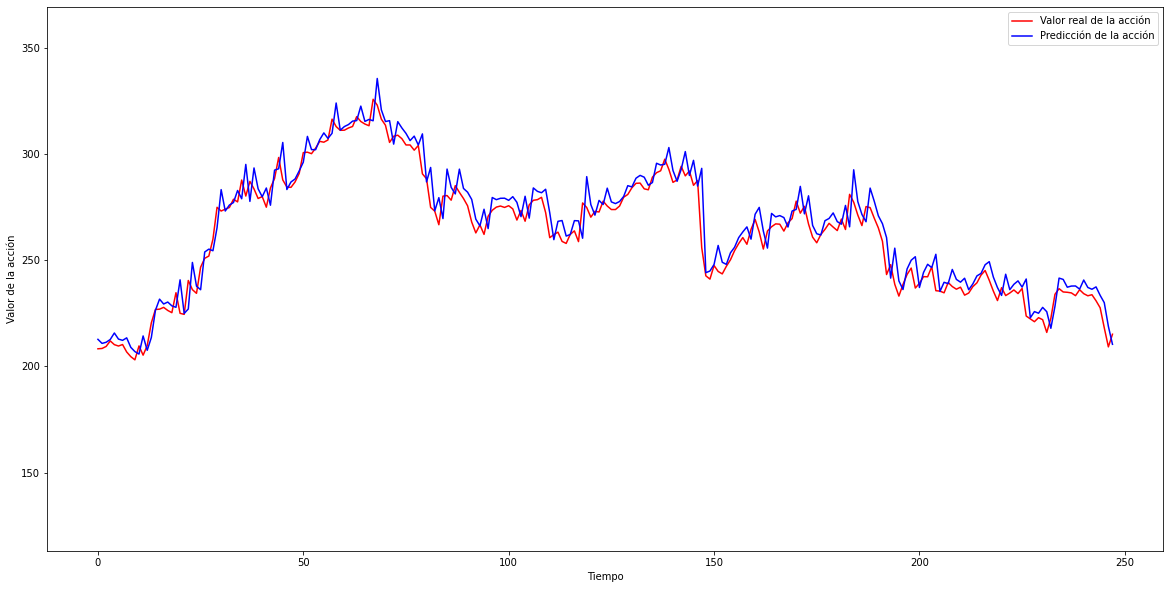

In [62]:
# Graficar resultadosdata[len_data - len_valid - time_step:].valuesdata['Close'][987:]
set_validation = data[len_data - len_valid :].values
plot_prediction(set_validation ,prediction)


In [63]:
train = pd.DataFrame(data[:len_train])
valid = pd.DataFrame(data[len_train:])
valid['Predictions'] = prediction


In [64]:
np.sqrt(np.mean(np.power(valid['Close'].values-valid['Predictions'].values,2)))
rmsLSTM = np.sqrt(np.mean(np.power(valid['Close'].values-valid['Predictions'].values,2)))
rmsLSTM 

7.3771567526574495

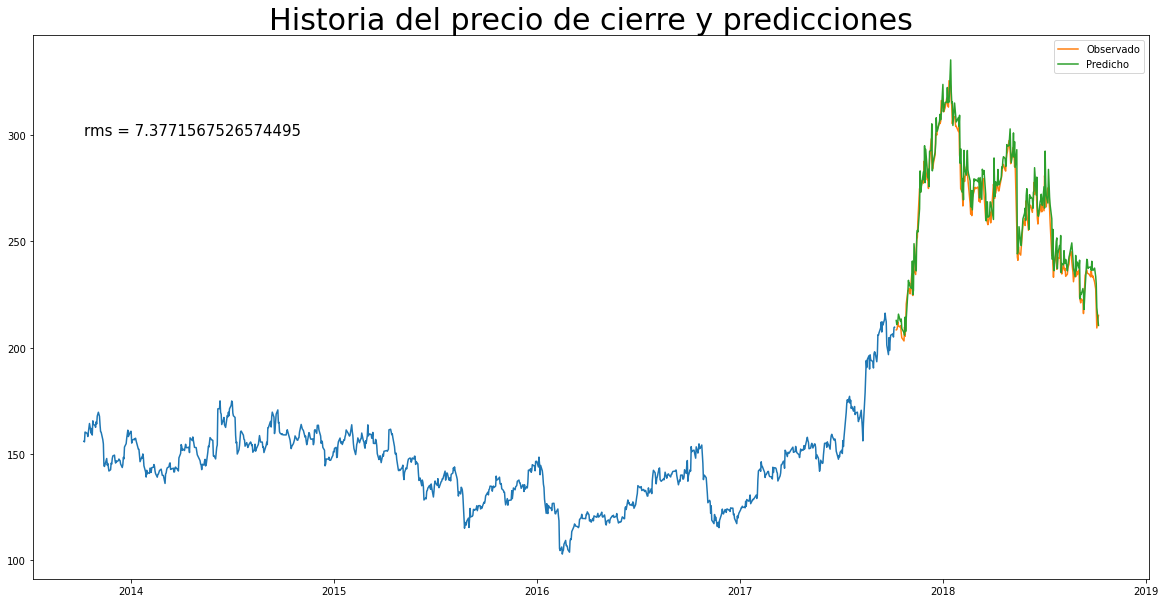

In [65]:
#for plotting
rmsLSTM = np.sqrt(np.mean(np.power(valid['Close'].values-valid['Predictions'].values,2)))

train = pd.DataFrame(data[:len_train])
valid = pd.DataFrame(data[len_train:])

valid['Predictions'] = prediction
plt.plot(train['Close'])
plot = plt.plot(valid[['Close','Predictions']])
plt.annotate("rms = "+str(rmsLSTM) , xy=(data.index[1],300), size = 15)
plt.legend(plot, ("Observado","Predicho"))
plt.title("Historia del precio de cierre y predicciones", size = 30)
plt.show()